# Loading Data

In [166]:
import torchvision
from torchvision import transforms
import torch
from torch.utils.data import DataLoader



# Define a transform to convert PIL images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

# Load the training dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data',  # Directory to store the dataset
    train=True,     # Specify training data
    download=True,  # Download if not already present
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',  # Directory to store the dataset
    train=False,     # Specify training data
    download=True,  # Download if not already present
    transform=transform
)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# 4. Access all labels directly from the dataset object
train_labels = train_dataset.targets
test_labels = test_dataset.targets

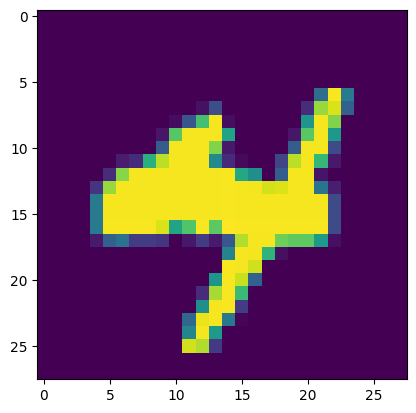

In [49]:
#heatmap view
from matplotlib import pyplot as plt
import random
random_image = random.choice(train_dataset)
plt.imshow(random_image[0].squeeze(),)

# Plan:
1) Get the data locally
2) Design feed forward calculation
3) Design loss calculation for end layer
4) Design grad/backgrad calculations
5) Design backprop updates
7) Design loss tracking graph

In [50]:
print(train_dataset.data[0:2].size())
X = train_dataset.data[0:2].flatten(1,-1)
print(X.size())
print(X.dtype)

torch.Size([2, 28, 28])
torch.Size([2, 784])
torch.uint8


In [161]:
act_name = 'sigmoid'
loss_type="cross_entropy"

## 2) Feed Forward calculation + Loss calculation:
We will use 3 hidden layers.
Initial size is 28*28 = 784, final is 10 classes (0,...,9)

In [162]:
import math
import torch
import torch.nn.functional as F
import torch.nn as nn


def matrix_generator(input_size, output_size):
    W = torch.empty(input_size, output_size)
    if ('sigmoid' or 'tanh') in act_name:
        nn.init.xavier_uniform(W)
    else:
        nn.init.kaiming_uniform(W)
    return W

def one_hot_encoding(labels, num_classes):
    one_hots = torch.nn.functional.one_hot(labels, num_classes=num_classes)
    return one_hots

def activation_function(input_tensor, activation_function_type: str = act_name):
    if activation_function_type == 'relu':
        return torch.relu(input_tensor)
    elif activation_function_type == 'leaky_relu':
        return F.leaky_relu(input_tensor, 0.01)
    elif activation_function_type == 'tanh':
        return F.tanh(input_tensor)
    elif activation_function_type == 'sigmoid' or activation_function_type == None:
        return torch.sigmoid(input_tensor)
    else:
        raise ValueError('Activation function type not supported')


# Loss function

def loss_function(output_tensor, target_tensor, loss_function_type: str = loss_type):
    if loss_function_type == 'cross_entropy':
        target_tensor = one_hot_encoding(target_tensor, output_tensor.size(1)).float()
        eps = 1e-12
        return -(target_tensor * torch.log(output_tensor + eps)).sum(dim=1).mean()
    elif loss_function_type == 'mse' or loss_function_type is None:
        target_tensor = one_hot_encoding(target_tensor, output_tensor.size(1)).float()
        return torch.nn.functional.mse_loss(output_tensor, target_tensor)
    else:
        raise ValueError('Loss function type not supported')

def initialize_params(num_hidden_layers):
    matrix_list = []
    input_size = 28*28
    for i in range(num_hidden_layers):
        hidden_size = int(num_classes*math.pow(2,num_hidden_layers-(i+1)))
        W = matrix_generator(input_size,hidden_size)
        input_size = hidden_size
        print('Matrix size:', W.size())
        # print(W)
        matrix_list.append(W)
    # print('Number of hidden layers:', len(matrix_list))

    #Bias initializations:
    bias_list = []
    for i in range(num_hidden_layers):
        matrix_output_size = matrix_list[i].shape[1]
        # bias = matrix_generator(matrix_output_size,1).reshape(1, -1)
        bias = torch.zeros(matrix_output_size,1).reshape(1, -1)
        # print('size of bias:', bias.size())
        bias_list.append(bias)
    
    return matrix_list, bias_list



def feed_forward(
    input_tensor, 
    matrix_list, 
    bias_list, 
    target_tensor,
    output_level= None):
    
    if output_level is None:
        output_level = len(matrix_list)
    
    compute_block_types = ['W', 'b','h','Z']
    compute_vect_memory = {}
    for i in range(output_level):
        for blck in compute_block_types:
            compute_vect_memory[f'{blck}_{i+1}'] = []
    
    compute_vect_memory['X_input'] = input_tensor

    for i in range(output_level):
        # print(i)
        compute_vect_memory[f'W_{i+1}'] = matrix_list[i]
        compute_vect_memory[f'b_{i+1}'] = bias_list[i]
        input_tensor = torch.matmul(input_tensor, matrix_list[i])# same as input_tensor @ matrix_list[i] 
        # print('Matrix size:',matrix_list[i].size())
        # print('bias size:',bias_list[i].size())
        input_tensor = input_tensor + bias_list[i] # ---> h = WZ+b or WX + b
        # print('out size:',input_tensor.size())
        compute_vect_memory[f'h_{i+1}'] = input_tensor
        input_tensor = activation_function(input_tensor) if i < (len(matrix_list) -1) else input_tensor # ---> Z
        compute_vect_memory[f'Z_{i+1}'] = input_tensor
    
    if output_level == len(matrix_list):
        input_tensor = torch.nn.functional.softmax(input_tensor, dim=1) #probabilities computed by softmax
        compute_vect_memory['p'] = input_tensor #Probabilities

        input_tensor = loss_function(input_tensor, target_tensor)
        compute_vect_memory['Loss'] = input_tensor
        
    return input_tensor, compute_vect_memory



# Matrix initializations:
input_size = 28*28
num_hidden_layers = 6
num_classes = 10


# Feed Forward calculation function: Done
#test
n_batch = 3
X_input = train_dataset.data[0:n_batch].flatten(1,-1).float()
targets = train_dataset.targets[0:n_batch]

matrix_list, bias_list = initialize_params(num_hidden_layers)
output, compute_memory = feed_forward(
    X_input,
    matrix_list,
    bias_list,
    targets
)

Matrix size: torch.Size([784, 320])
Matrix size: torch.Size([320, 160])
Matrix size: torch.Size([160, 80])
Matrix size: torch.Size([80, 40])
Matrix size: torch.Size([40, 20])
Matrix size: torch.Size([20, 10])


C:\Users\Administrator\AppData\Local\Temp\ipykernel_20048\2986480587.py:10: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(W)


# 4) Grad / Backprop grad calculation for each param:

## 4.1) Node linking:
After handwritting derivation by hand, I see the repeating paths.

So I will design nodes with children being the direct variable link.

For eg: 

Z_i = Activation_function(H), so Z_i ---link--- H,

H = W.Z_(i-1) + b, so H --- Z_(i-1), H --- W and H --- b

Simpler with NetworkX , where you have nodes of different types

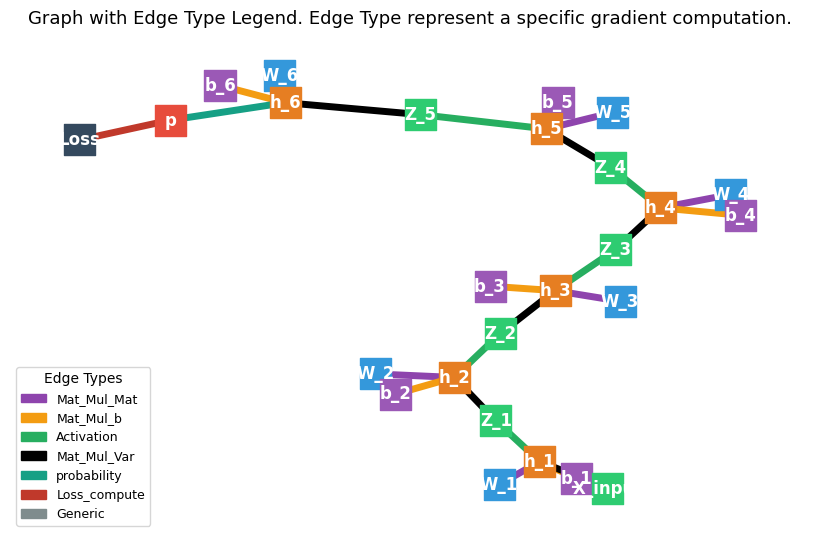

In [163]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def add_typed_edge(G, src, dst):
    src_type = G.nodes[src]["type"]
    dst_type = G.nodes[dst]["type"]
    edge_type = infer_edge_type(src_type, dst_type)
    G.add_edge(src, dst, type=edge_type)

def find_simple_path(G, src, dst):
    paths = list(nx.all_simple_paths(G, source=src, target=dst))
    if not paths:
        return []
    # pick the path with maximum length
    return max(paths, key=len)


def find_edge_type(G, src, dst):
    src_type = G.nodes[src]["type"]
    dst_type = G.nodes[dst]["type"]
    edge_type = infer_edge_type(src_type, dst_type)
    return edge_type

# Define edge type inference
def infer_edge_type(src_type, dst_type):
    if src_type == "matrix_Layer" and dst_type == "matrix_compute_vect":
        edge_type = "Mat_Mul_Mat"
    elif src_type == "bias_vect" and dst_type == "matrix_compute_vect":
        edge_type = "Mat_Mul_b"
    elif src_type == "matrix_compute_vect" and dst_type == "Activated_vect":
        edge_type = "Activation"
    elif (src_type == "Activated_vect" or src_type == "X_input") and dst_type == "matrix_compute_vect":
        edge_type = "Mat_Mul_Var"
    elif src_type == "Activated_vect" and dst_type == "probability_compute":
        edge_type = "probability"
    elif src_type == "matrix_compute_vect" and dst_type == "probability_compute":
        edge_type = "probability"
    elif src_type == "probability_compute" and dst_type == "Loss":
        edge_type = "Loss_compute"
    else:
        edge_type = "Generic"

    return edge_type

def gradient_network_graph(num_hidden_layers):
    # --- Define graph ---
    G = nx.Graph()

    # Create graph from NN network to compute gradients:

    for i in range(num_hidden_layers):

        G.add_node(f'W_{i+1}', type= "matrix_Layer") # Matrix hidden layer
        G.add_node(f'b_{i+1}', type= "bias_vect") # Bias vector
        G.add_node(f'h_{i+1}', type= "matrix_compute_vect") # h = W.Z+b
        if i < (num_hidden_layers-1):
            G.add_node(f'Z_{i+1}', type= f"Activated_vect") # Z = A(h)

        add_typed_edge(G,f'W_{i+1}', f'h_{i+1}') # h = W.Z+b
        add_typed_edge(G,f'b_{i+1}', f'h_{i+1}') # h = W.Z+b


        if i == 0:
            G.add_node(f"X_input" , type = "X_input")
            add_typed_edge(G,'X_input', f'h_{i+1}') # h = W.X+b
        else:
            add_typed_edge(G,f'Z_{i}', f'h_{i+1}') # h_(i+1) = W.Z_i+b

        if i < (num_hidden_layers-1):
            add_typed_edge(G,f'h_{i+1}', f'Z_{i+1}')  # Z = A(h)  
    
        if i == (num_hidden_layers-1):
            G.add_node('p', type= "probability_compute")
            G.add_node(f'Loss', type= "Loss")

            add_typed_edge(G,f'h_{i+1}', f'p')
            add_typed_edge(G,'p', f'Loss') # h = W.X+b
    
    return G

def draw_gradient_graph(G):
    # --- color maps (from your previous dicts) ---
    node_color_map = {
        "X_input": "#2ECC71",
        "matrix_Layer": "#3498DB",
        "bias_vect": "#9B59B6",
        "matrix_compute_vect": "#E67E22",
        "Activated_vect": "#2ECC71",
        "probability_compute": "#E74C3C",
        "Loss": "#34495E"
    }

    edge_color_map = {
        "Mat_Mul_Mat": "#8E44AD",
        "Mat_Mul_b": "#F39C12",
        "Activation": "#27AE60",
        "Mat_Mul_Var": "#000000",
        "probability": "#16A085",
        "Loss_compute": "#C0392B",
        "Generic": "#7F8C8D"
    }

    # --- assign colors using the maps ---
    node_colors = [node_color_map[G.nodes[n]["type"]] for n in G.nodes]
    edge_colors = [edge_color_map[G.edges[e]["type"]] for e in G.edges]

    # --- layout and draw ---
    sp = 10
    pos = {'X_input': [sp, -3*sp], 'Loss': [-sp, sp]}
    fixed = ['X_input', 'Loss']
    pos = nx.spring_layout(G, pos=pos, fixed=fixed, seed=42)

    plt.figure(figsize=(8, 5))
    nx.draw(
        G, pos,
        with_labels=True,
        node_shape='s',
        node_size=500,
        node_color=node_colors,
        edge_color=edge_colors,
        font_color='white',
        font_weight='bold',
        # arrows=True,
        width=5
    )
    # --- Create legend for edge types ---
    legend_handles = [
        mpatches.Patch(color=color, label=edge_type)
        for edge_type, color in edge_color_map.items()
    ]

    plt.legend(
        handles=legend_handles,
        title="Edge Types",
        loc="lower left",
        fontsize=9,
        title_fontsize=10,
        frameon=True
    )

    plt.title("Graph with Edge Type Legend. Edge Type represent a specific gradient computation.", fontsize=13)
    plt.axis("off")
    plt.show()


G = gradient_network_graph(num_hidden_layers)
draw_gradient_graph(G)

In [205]:
len(train_dataset)

60000

In [ ]:
find_simple_path(G,'Loss','W_2')

['Loss',
 'p',
 'h_6',
 'Z_5',
 'h_5',
 'Z_4',
 'h_4',
 'Z_3',
 'h_3',
 'Z_2',
 'h_2',
 'W_2']

In [134]:
find_simple_path(G,'Loss','W_1')

['Loss',
 'p',
 'h_6',
 'Z_5',
 'h_5',
 'Z_4',
 'h_4',
 'Z_3',
 'h_3',
 'Z_2',
 'h_2',
 'Z_1',
 'h_1',
 'W_1']

## 4.2) Gradient Formulas per edge type:

We will calculate gradient block per edge type (dh/dz, dh/dw). The gradient is just the multiplications (chain rule) of the blocks

We will also update the params using learning rate and gradient descent formula

In [ ]:
# def edge_type_partial_gradient_block(G,src, dst, compute_vect_memory, p_label, N_batch = 1,act_name = act_name):
#     edge_type = find_edge_type(G, src, dst)
#     src_val = compute_vect_memory[src]
#     dst_val = compute_vect_memory[dst]

#     if edge_type == "Mat_Mul_Mat": #dh/dW
#         index_W = int(src.split('_')[1])
#         previous_index = index_W - 1

#         if previous_index == 0: # We are at the input layer of NN
#             Z = compute_vect_memory['X_input']
#             # print('At First Layer')
#             diff_block = Z.unsqueeze(-1)
#             Z = sum_at_x_dim(Z)
#             # print('At Hidden Layer')
#             Z_T = torch.transpose(Z,0,1)
#             diff_block = Z_T
            
#         else: # Hidden Layer
#             Z = compute_vect_memory[f'Z_{previous_index}']
#             Z = sum_at_x_dim(Z)
#             # print('At Hidden Layer')
#             Z_T = torch.transpose(Z,0,1)
#             diff_block = Z_T

#         # print(Z.size())
        
        
#     elif edge_type == "Mat_Mul_b": #dh/db
#         b = sum_at_x_dim(src_val)
#         dh_db = torch.eye(b.size(-1))
#         diff_block = dh_db

#     elif edge_type == "Activation": # dz/dh
#         h = sum_at_x_dim(src_val)
#         if act_name == "sigmoid":
#             a = torch.sigmoid(h)
#             diff = a * (1 - a)

#         elif act_name == "tanh":
#             a = torch.tanh(h)
#             diff = 1 - a ** 2

#         elif act_name == "relu":
#             diff = (h > 0).float()

#         elif act_name == "leaky_relu":
#             negative_slope = 0.01
#             diff = torch.where(h > 0, torch.ones_like(h), torch.full_like(h, negative_slope))

#         diff_block = torch.diag(diff.flatten())
#         # one_vect = torch.ones_like(h)
#         # diff_block = torch.diag((activation_function(h) * (one_vect - activation_function(h))).flatten())
        
#         # print('h:',h)
#         # print(f'{act_name} A(h):',activation_function(h))

#     elif edge_type == "Mat_Mul_Var": #dh/dz h = WZ + b
#         index_Z = int(src.split('_')[1]) if 'input' not in src else 0
#         next_index = index_Z + 1
#         W = compute_vect_memory[f'W_{next_index}']
#         diff_block = W.T
#         # print('W_size:',W.size())
#         # print('diff_block size',diff_block.size())
#         # print('diff_block:', diff_block)

#     elif edge_type == "probability": #dp/dh Softmax or ...
#         p = sum_at_x_dim(dst_val)
#         p_t = torch.transpose(p, 0,1)
#         print('p:',p.size())
#         prod = torch.matmul(p_t,p)
#         prod = torch.bmm(p.unsqueeze(2), p.unsqueeze(1))
#         print('prod:',prod.size())
#         diff_block =  torch.diag(p.flatten()) - prod
#         diff_block = torch.eye(p.size(1))

#     elif edge_type == "Loss_compute": # dL/dp  
#         p_output = sum_at_x_dim(compute_vect_memory[src])
#         p_label = sum_at_x_dim(p_label)
#         # diff_block = (2/N_batch)*(p_output - p_label)
#         diff_block = -(1 / N_batch) * (p_label / (p_output + 1e-12))  # dL/dp
#         # diff_block = ()
#     diff_block_un = diff_block.unsqueeze(-1)
#     return diff_block



def edge_type_partial_gradient_block(G,src, dst, compute_vect_memory, p_label, N_batch = 1,act_name = act_name):
    edge_type = find_edge_type(G, src, dst)
    src_val = compute_vect_memory[src]
    dst_val = compute_vect_memory[dst]

    if edge_type == "Mat_Mul_Mat": #dh/dW
        index_W = int(src.split('_')[1])
        previous_index = index_W - 1

        if previous_index == 0: # We are at the input layer of NN
            Z = compute_vect_memory['X_input']
            # print('At First Layer')
            diff_block = Z.unsqueeze(-1)
            
        else: # Hidden Layer
            Z = compute_vect_memory[f'Z_{previous_index}'] #(B,dim)
            diff_block = Z.unsqueeze(-1)

        
        
    elif edge_type == "Mat_Mul_b": #dh/db
        b = sum_at_x_dim(src_val)
        Idm = torch.eye(b.size(1))
        diff_block = Idm.unsqueeze(0).expand(N_batch,Idm.size(0), Idm.size(1))

    elif edge_type == "Activation": # dz/dh
        h = sum_at_x_dim(src_val)
        if act_name == "sigmoid":
            a = torch.sigmoid(h)
            diff = a * (1 - a)

        elif act_name == "tanh":
            a = torch.tanh(h)
            diff = 1 - a ** 2

        elif act_name == "relu":
            diff = (h > 0).float()

        elif act_name == "leaky_relu":
            negative_slope = 0.01
            diff = torch.where(h > 0, torch.ones_like(h), torch.full_like(h, negative_slope))

        diff_block = torch.diag_embed(diff)

    elif edge_type == "Mat_Mul_Var": #dh/dz h = WZ + b
        index_Z = int(src.split('_')[1]) if 'input' not in src else 0
        next_index = index_Z + 1
        W = compute_vect_memory[f'W_{next_index}']
        WT = W.T
        diff_block = (WT).unsqueeze(0).expand(N_batch, WT.size(0), WT.size(1))
        

    elif edge_type == "probability": #dp/dh Softmax or ...
        p = sum_at_x_dim(dst_val)
        prod = torch.bmm(p.unsqueeze(2), p.unsqueeze(1))
        diag = torch.diag_embed(p)
        diff_block =  diag - prod
        

    elif edge_type == "Loss_compute": # dL/dp  
        p_output = sum_at_x_dim(compute_vect_memory[src])
        p_label = sum_at_x_dim(p_label)
        # diff_block = (2/N_batch)*(p_output - p_label)
        diff_block = -(1 / N_batch) * (p_label / (p_output + 1e-12))  # dL/dp
        diff_block = diff_block.unsqueeze(-2)
        
    # print('diff_block size:',diff_block.size())
    return diff_block

# def edge_type_partial_gradient_block(G, src, dst, compute_vect_memory, p_label, N_batch=1, act_name=act_name):
#     edge_type = find_edge_type(G, src, dst)
#     src_val = compute_vect_memory[src]
#     dst_val = compute_vect_memory[dst]

#     if edge_type == "Mat_Mul_Mat":            # dh/dW  -> return Z (B, in)
#         index_W = int(src.split('_')[1])
#         prev = index_W - 1
#         Z = compute_vect_memory['X_input'] if prev == 0 else compute_vect_memory[f'Z_{prev}']  # (B, in)
#         diff_block = Z  # keep batch; outer product will be formed at 'W_' node

#     elif edge_type == "Mat_Mul_b":            # dh/db -> ones (B, out, 1)
#         b = src_val                             # (B, out)
#         diff_block = torch.ones_like(b).unsqueeze(-1)  # (B, out, 1)

#     elif edge_type == "Activation":           # dz/dh -> diag(a'(h))  as (B, out, out)
#         h = src_val                             # (B, out)
#         if act_name == "sigmoid":
#             a = torch.sigmoid(h); diff = a * (1 - a)
#         elif act_name == "tanh":
#             a = torch.tanh(h); diff = 1 - a**2
#         elif act_name == "relu":
#             diff = (h > 0).float()
#         elif act_name == "leaky_relu":
#             diff = torch.where(h > 0, torch.ones_like(h), torch.full_like(h, 0.01))
#         diff_block = torch.diag_embed(diff)     # (B, out, out)

#     elif edge_type == "Mat_Mul_Var":          # dh/dz with h = Z W + b
#         index_Z = int(src.split('_')[1]) if 'input' not in src else 0
#         W = compute_vect_memory[f'W_{index_Z+1}']     # (in, out)
#         diff_block = W.unsqueeze(0).expand(N_batch, *W.shape)  # (B, in, out)

#     elif edge_type == "probability":          # dp/dz (softmax): identity, since CE shortcut
#         p = compute_vect_memory['p']            # (B, C)
#         B, C = p.shape
#         diff_block = torch.eye(C, device=p.device).unsqueeze(0).expand(B, C, C)  # (B, C, C)

#     elif edge_type == "Loss_compute":         # dL/dp  (cross-entropy shortcut)
#         p = compute_vect_memory[src]            # (B, C)
#         y = p_label.float()                     # (B, C)
#         diff_block = (p - y).unsqueeze(-1) / N_batch   # (B, C, 1)

#     return diff_block



def sum_at_x_dim(input_tensor, dim = 0):
    # return input_tensor.sum(dim).reshape(1,-1)
    return input_tensor

def compute_gradient_update_params(G,src_init, dst_final,matrix_list,bias_list,compute_memory, target_tensor,N_batch=1):
    grad_tot = torch.ones(N_batch,1,1)
    path_blocks = find_simple_path(G,src_init,dst_final)
    # print(path_blocks)
    grad_blocks = []
    grad_blocks_dict = {}
    
    for i in range(len(path_blocks)-1):
        src = path_blocks[i+1]
        dst = path_blocks[i]
        # print(f'------------------{src}->{dst} -------------------')
        grad_block = edge_type_partial_gradient_block(G, src, dst, compute_memory,target_tensor, N_batch)
        grad_blocks.append(grad_block)
        grad_blocks_dict[f'{src}-->{dst}'] = grad_block
        
        #Chain Rule
        if ('W_' not in src) and ('b_' not in src):
            grad_tot = torch.bmm(grad_tot, grad_block)
        elif ('W_' in src):# and ('W_1' not in src):
            grad_tot = torch.matmul(grad_block, grad_tot)
        elif ('b_' in src):
            grad_tot = torch.matmul(grad_tot, grad_block)
        # print('gradient tot:',grad_tot.norm())
        # print('-------------------------------------------')
    grad_tot = grad_tot.sum(dim=0)
    
    return grad_blocks_dict,grad_tot,matrix_list,bias_list

# def compute_gradient_update_params(G, src_init, dst_final, matrix_list, bias_list, compute_memory, target_tensor, N_batch=1):
#     grad_tot = None  # we’ll keep it as (B, d, 1) except at param nodes
#     path_blocks = find_simple_path(G, src_init, dst_final)
#     grad_blocks_dict = {}

#     for i in range(len(path_blocks) - 1):
#         src = path_blocks[i + 1]
#         dst = path_blocks[i]

#         grad_block = edge_type_partial_gradient_block(G, src, dst, compute_memory, target_tensor, N_batch)
#         grad_blocks_dict[f'{src}-->{dst}'] = grad_block

#         # ---- Chain rule (batched) ----
#         # For non-parameter edges, keep grad_tot as (B, d, 1)
#         if ('W_' not in src) and ('b_' not in src):
#             # Initialize grad_tot
#             if grad_tot is None:
#                 # If block is (B, d, 1) we take it; if it's (B, d) (only for Mat_Mul_Mat), unsqueeze
#                 grad_tot = grad_block if grad_block.dim() == 3 else grad_block.unsqueeze(-1)
#             else:
#                 # Ensure batch 3D
#                 if grad_block.dim() == 2:  # (B, d) -> (B, d, 1) to allow bmm as outer-like
#                     grad_block = grad_block.unsqueeze(-1)
#                 # If grad_block is diagonal (B, d, d) or linear map (B, m, n):
#                 # Always do: grad_tot = grad_block @ grad_tot  -> (B, new_d, 1)
#                 if grad_block.size(-1) == grad_tot.size(-2):     # (..., n) x (n, 1)
#                     grad_tot = torch.bmm(grad_block, grad_tot)
#                 else:
#                     # If grad_block is (B, d, 1) (e.g., accidental), just Hadamard:
#                     grad_tot = grad_tot * grad_block

#         elif ('W_' in src):
#             # Parameter node: form dW from batch outer products Z ⊗ g_h, then reduce
#             iW = int(src.split('_')[1]) - 1
#             Z_prev = grad_block                      # (B, in)
#             g_h = grad_tot.squeeze(-1)               # (B, out)

#             # (B, in, 1) @ (B, 1, out) -> (B, in, out); then mean over batch
#             dW = torch.bmm(Z_prev.unsqueeze(2), g_h.unsqueeze(1)).mean(dim=0)  # (in, out)
#             grad_tot = dW  # return 2D so the caller can apply the update shape (in, out)

#         elif ('b_' in src):
#             # Parameter node: db = mean over batch of current column grad
#             g_h = grad_tot.squeeze(-1)               # (B, out)
#             db = g_h.mean(dim=0, keepdim=True)       # (1, out)
#             grad_tot = db  # 2D, matches bias shape

#     return grad_blocks_dict, grad_tot, matrix_list, bias_list

def backward_pass(G,src_init,matrices,biases,compute_memory, target_tensor,num_hidden_layers,N_batch=1):
    matrix_list = matrices
    bias_list = biases
    for i in range(num_hidden_layers):
        dst_W = f'W_{i+1}'
        dst_b = f'b_{i+1}'
        _,_,matrix_list, _ = compute_gradient_update_params(G,src_init, dst_W,matrix_list,bias_list,compute_memory, target_tensor,N_batch)
        _,_,_, bias_list = compute_gradient_update_params(G,src_init, dst_b,matrix_list,bias_list,compute_memory, target_tensor,N_batch)
    
    return matrix_list, bias_list


lr = 0.01
n_batch = 30
X_input = train_dataset.data[0:n_batch].flatten(1,-1).float()
targets = train_dataset.targets[0:n_batch]



# Matrix initializations:
input_size = 28*28
num_hidden_layers = 6
num_classes = 10


# Feed Forward / Backward Pass Test
n_batch = 3
X_input = train_dataset.data[0:n_batch].flatten(1,-1).float()
targets = train_dataset.targets[0:n_batch]

matrix_list, bias_list = initialize_params(num_hidden_layers)
output, compute_memory = feed_forward(
    X_input,
    matrix_list,
    bias_list,
    targets)

G = gradient_network_graph(num_hidden_layers)

init_src = 'Loss'
final_dst = 'W_1'

target_tensors = one_hot_encoding(train_dataset.targets[0:n_batch],10)
grds_dict,tot,_,_ = compute_gradient_update_params(G,init_src,final_dst,matrix_list, bias_list,compute_memory, target_tensors,n_batch)

Matrix size: torch.Size([784, 320])
Matrix size: torch.Size([320, 160])
Matrix size: torch.Size([160, 80])
Matrix size: torch.Size([80, 40])
Matrix size: torch.Size([40, 20])
Matrix size: torch.Size([20, 10])


C:\Users\Administrator\AppData\Local\Temp\ipykernel_20048\2986480587.py:10: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(W)


## 6) Train and show loss plot

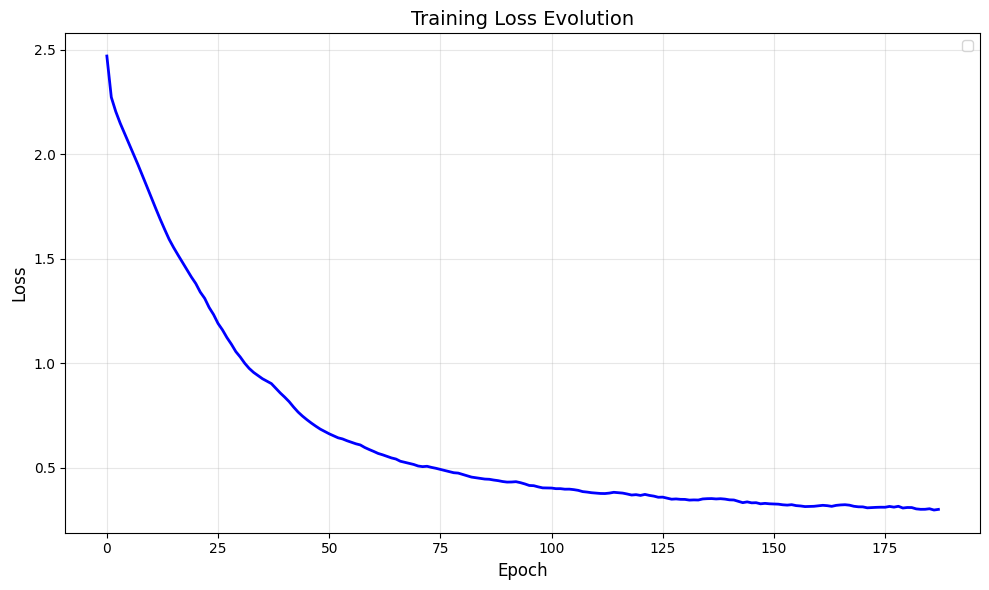

Epoch 189/200:  56%|█████▌    | 669/1200 [00:03<00:02, 179.97it/s]


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

lr = 0.001
num_hidden_layers = 3
n_batch = 50
num_classes = 10
num_epochs = 200  # ⬅️ number of epochs you want

min_delta = 1e-4
best_loss = float('inf')
patience = 8

matrix_list, bias_list = initialize_params(num_hidden_layers)

X_test = test_dataset.data.flatten(1, -1).float()
targets_test = test_dataset.targets

losses = []
losses_test = []
wait = 0

G = gradient_network_graph(num_hidden_layers)

for epoch in range(num_epochs):
    epoch_loss = 0.0
    total_batches = 0

    

    # --- accumulate gradients over all batches ---
    accumulated_dW = [torch.zeros_like(W) for W in matrix_list]
    accumulated_db = [torch.zeros_like(b) for b in bias_list]
    grad_dict = {}
    for i in range(num_hidden_layers):
        grad_dict[f'W_{i+1}'] = []
        grad_dict[f'b_{i+1}'] = []

    for step in tqdm(range(0, len(train_dataset), n_batch), desc=f"Epoch {epoch+1}/{num_epochs}"):

        # pick random indices
        # idx = torch.randint(0, len(train_dataset), (n_batch,))

        # # select corresponding examples
        # X_input = train_dataset.data[idx].flatten(1, -1).float()
        # targets = train_dataset.targets[idx]

        X_input = train_dataset.data[step:step+n_batch].flatten(1, -1).float()
        targets = train_dataset.targets[step:step+n_batch]

        # ---- Forward pass ----
        loss_output, compute_memory = feed_forward(
            X_input,
            matrix_list,
            bias_list,
            targets
        )

        epoch_loss += loss_output.item()


        total_batches += 1

        # ---- Backward pass (accumulate gradients) ----
        init_src = 'Loss'
        target_tensors = one_hot_encoding(targets, num_classes)

        # compute gradients (but don’t update weights yet)
        for i in range(num_hidden_layers):
            _, grad_W_batch, _, _ = compute_gradient_update_params(
                G, init_src, f'W_{i+1}', matrix_list, bias_list, compute_memory, target_tensors, n_batch
            )

            _, grad_b_batch, _, _ = compute_gradient_update_params(
                G, init_src, f'b_{i+1}', matrix_list, bias_list, compute_memory, target_tensors, n_batch
            )

            # gradient clipping:
            grad_norm = grad_W_batch.norm()
            if grad_norm > 1.0:
                grad_W_batch = grad_W_batch / grad_norm

            grad_dict[f'W_{i+1}'] = grad_W_batch
            grad_dict[f'b_{i+1}'] = grad_b_batch

        # accumulate (this assumes your compute_gradient_update_params
        # returns matrix_list and bias_list that contain raw gradient updates)
        
        for i in range(len(matrix_list)):
            accumulated_dW[i] += grad_dict[f'W_{i+1}']
            accumulated_db[i] += grad_dict[f'b_{i+1}']
        # print('Gradient', accumulated_dW[0].norm())

    # ---- Update parameters once per epoch ----
    for i in range(len(matrix_list)):
        # print(f'accum{i}:',accumulated_dW[i].norm())
        # print('before:', matrix_list[i].norm().item())
        matrix_list[i] -= lr * (accumulated_dW[i])
        bias_list[i] -= lr * (accumulated_db[i])
        # print('After:', matrix_list[i].norm().item())

    # ---- Log epoch loss ----
    avg_loss = epoch_loss / total_batches
    losses.append(avg_loss)

    
    loss_output_test, _ = feed_forward(
        X_test,
        matrix_list,
        bias_list,
        targets_test
    )
    
    losses_test.append(loss_output_test.item()/total_batches)

    
    clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(losses)), losses, 'b-', linewidth=2)
    # plt.plot(range(len(losses_test)), losses_test, 'r-', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training Loss Evolution', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---- Early stopping ----
    if avg_loss + min_delta < best_loss:
        best_loss = avg_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}. Best loss: {best_loss:.6f}")
            break

# Final plot
clear_output(wait=True)
plt.figure(figsize=(10, 6))
plt.plot(range(len(losses)), losses, 'b-', linewidth=2)
# plt.plot(range(len(losses_test)), losses_test, 'r-', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Evolution (Final)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


target: 9


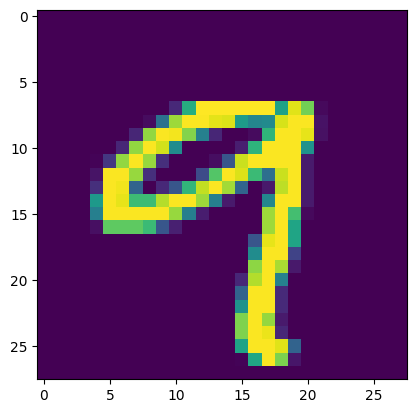

In [214]:
# Feed Forward test
from matplotlib import pyplot as plt
import random
random_image = random.choice(test_dataset)
plt.imshow(random_image[0].squeeze(),)
print('target:',random_image[1])

predict:tensor([2]), label:1
target: 1


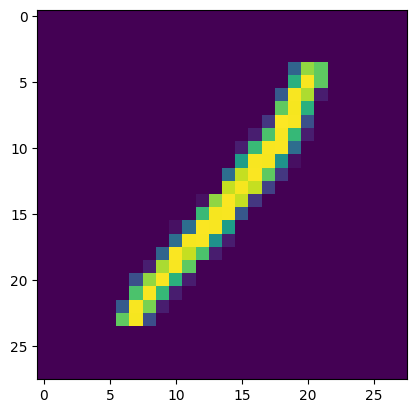

In [243]:
random_image = random.choice(test_dataset)
X_input = random_image[0].flatten(1,-1).float()
targets = torch.tensor(random_image[1])

output, compute_memory = feed_forward(
    X_input,
    matrix_list,
    bias_list,
    targets
)
# chage value to x 
y_predict = torch.argmax(compute_memory['p'], dim=1)

print(f'predict:{y_predict}, label:{targets}')

plt.imshow(random_image[0].squeeze(),)
print('target:',random_image[1])
